# Analysis of An $AR(1)$ Model in pyMC3

In [2]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.8


Consider the following AR(1) process, initialized in the
infinite past:
$$
   y_t = \theta y_{t-1} + \epsilon_t,
$$
where $\epsilon_t \overset{iid}{\sim} {\cal N}(0,1)$.  Suppose you'd like to learn about $\theta$ from a a sample of observations $Y^T = \{ y_0, y_1,\ldots, y_T \}$.

First, let's generate some synthetic sample data. We simulate the 'infinite past' by generating 10,000 samples from an AR(1) process and then discarding the first 5,000:

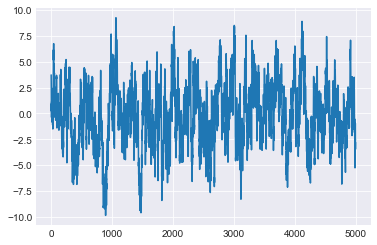

In [3]:
np.random.seed(seed=42)

T = 10000
y = np.zeros((T,))
theta = 0.95

for i in range(1, T):
    y[i] = theta * y[i - 1] + np.random.normal()

y = y[-5000:]
plt.plot(y);

Consider the following prior for $\theta$: $\theta \sim {\cal N}(0,\tau^2)$.
We can show that the posterior distribution of $\theta$ is of the form

$$
 \theta |Y^T \sim {\cal N}( \tilde{\theta}_T, \tilde{V}_T),
$$

where

$$
\begin{eqnarray}
        \tilde{\theta}_T &=& \left( \sum_{t=1}^T y_{t-1}^2 + \tau^{-2} \right)^{-1} \sum_{t=1}^T y_{t}y_{t-1} \\
        \tilde{V}_T      &=& \left( \sum_{t=1}^T y_{t-1}^2 + \tau^{-2} \right)^{-1}
\end{eqnarray}
$$

In [4]:
with pm.Model() as ar1:
    theta_ = pm.Normal(
        "theta", 0.0, 1
    )  # we assume process is stationary, so -1 < k_ < 1
    tau_ = pm.Exponential("tau", 0.5)  # the variance of the innovation term
    center = pm.Normal(
        "center", mu=y.mean(), sigma=2.5
    )  # prior for the processs mean initially centred on the population mean

    likelihood = pm.AR1("likelihood", k=theta_, tau_e=tau_, observed=y - center)

    trace = pm.sample(init="adapt_diag", random_seed=42)
    idata = az.from_pymc3(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [center, tau, theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.


We can see that even though the sample data did not start at zero, the true center of zero is captured in the highest posterior density of the estimated center. Likewise, the HPD of the autocorrelation parameter 𝜃 and the variance term of the \epsilon_t, called tau, capture the true values (0.95 and 1, respectively).

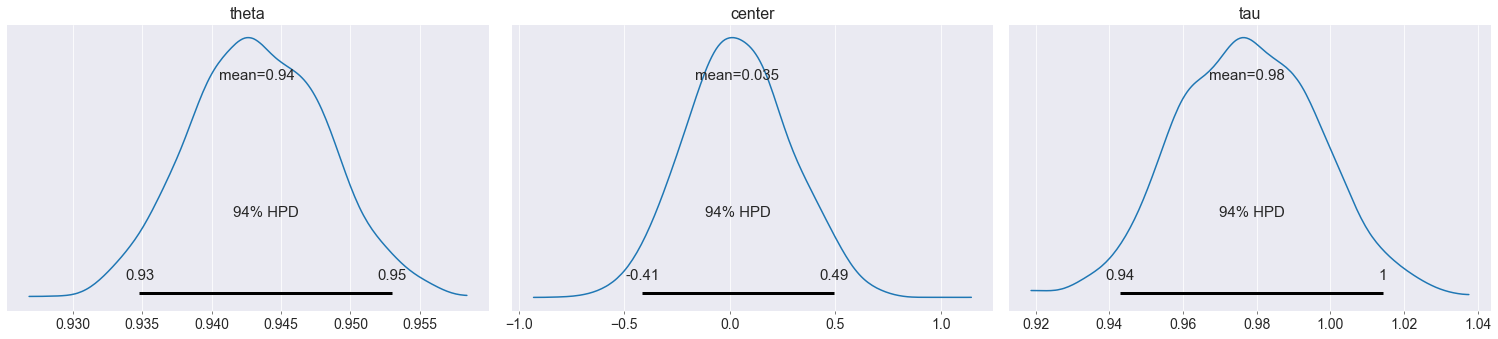

In [5]:
_ = pm.plots.plot_posterior(trace)

In [6]:
mup = ((y[:-1] ** 2).sum() + np.mean(trace["tau"]) ** -2) ** -1 * np.dot(y[:-1], y[1:])
Vp = ((y[:-1] ** 2).sum() + np.mean(trace["tau"]) ** -2) ** -1

print("Mean: {:5.3f} (exact = {:5.3f})".format(trace["theta"].mean(), mup))
print("Std: {:5.3f} (exact = {:5.3f})".format(trace["theta"].std(), np.sqrt(Vp)))

Mean: 0.943 (exact = 0.943)
Std: 0.005 (exact = 0.005)


## Extension to AR(p)
We can instead estimate an AR(2) model using pyMC3.

$$
 y_t = \phi_1 y_{t-1} + \phi_2 y_{t-2} + \epsilon_t.
$$

The `AR` distribution infers the order of the process by size the of `rho` argmument passed to `AR`. 

In [7]:
with pm.Model() as ar2:
    beta = pm.Normal("beta", mu=0, sigma=tau, shape=2)
    likelihood = pm.AR("likelihood", beta, sigma=1.0, observed=y)

In [8]:
with ar2:
    trace = pm.sample(1000, tune=2000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:03<00:00, 3772.52draws/s]
The number of effective samples is smaller than 25% for some parameters.


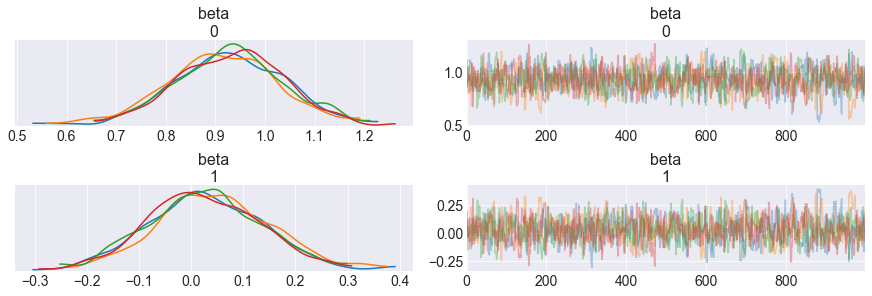

In [9]:
az.plot_trace(trace);

You can also pass the set of AR parameters as a list. 

In [13]:
with pm.Model() as ar3:
    beta0 = pm.Normal("beta0", mu=0, sigma=tau)
    beta1 = pm.Uniform("beta1", -1, 1)
    likelhood = pm.AR("y", [beta0, beta1], sigma=1.0, observed=y)

In [14]:
with ar3:
    trace = pm.sample(1000, tune=2000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta1, beta0]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [00:03<00:00, 3496.54draws/s]
The acceptance probability does not match the target. It is 0.8875840301924248, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8828855631522673, but should be close to 0.8. Try to increase the number of tuning steps.


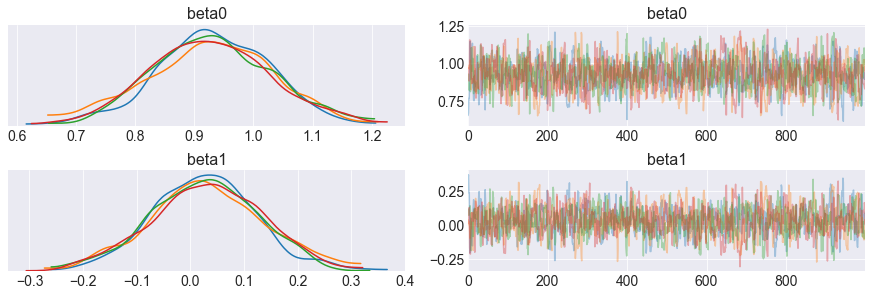

In [15]:
az.plot_trace(trace);

In [7]:
%load_ext watermark
%watermark -n -u -v -iv -w

pymc3 3.8
numpy 1.18.4
arviz 0.7.0
last updated: Fri May 15 2020 

CPython 3.8.2
IPython 7.14.0
watermark 2.0.2
